In [251]:
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [252]:
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
%pip install fvcore iopath
%pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Note: you may need to restart the kernel to use updated packages.
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu111_pyt1100/download.html
Note: you may need to restart the kernel to use updated packages.


In [253]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [254]:
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras,
    FoVOrthographicCameras ,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    OpenGLPerspectiveCameras
)

In [255]:
# Create IRS/lists/IRS_metal_test.list for our usage
from pathlib import Path

OG_LIST = 'IRS/lists/IRS_metal_test.list'
NEW_LIST = 'IRS/lists/IRS_restaurant_metal_test.list'

to_write = []
with Path(OG_LIST).open('r') as all_list:
    lines = all_list.readlines()
    for line in lines:
        if "restaurant" not in line:
            continue
        to_write.append(line.replace('SIRSDataset/restaurant', 'Restaurant'))

with Path(NEW_LIST).open('w') as f:
    for item in to_write:
        f.write("%s" % item)

In [256]:
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


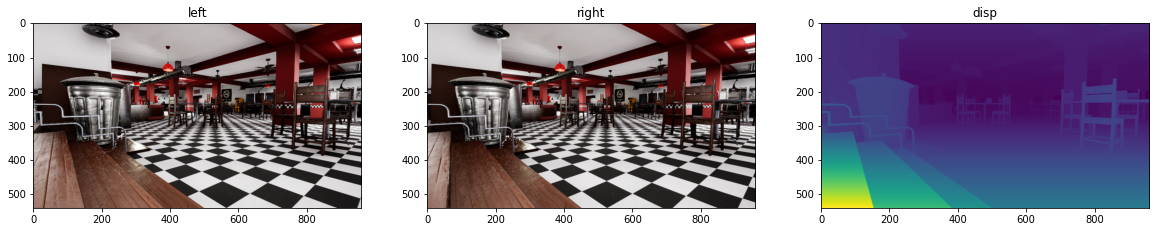

In [257]:
# Load the IRS/lists/IRS_metal_test.list file into the IRSDataset
%load_ext autoreload
%autoreload 2

from IRS.dataloader.IRSLoader import IRSDataset


DATA_DIR = "/data"

dataset = IRSDataset(txt_file=NEW_LIST, root_dir=DATA_DIR, phase='visualize')
# good: 8, 12, 15, 26
sample = dataset[8]
im_l, im_r, disp = sample['img_left'], sample['img_right'], sample['gt_disp']

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,3,1)
plt.title('left')
ax1.imshow(im_l.moveaxis(0, -1))
ax2 = fig.add_subplot(1,3,2)
plt.title('right')
ax2.imshow(im_r.moveaxis(0, -1))
ax3 = fig.add_subplot(1,3,3)
plt.title('disp')
ax3.imshow(disp.moveaxis(0, -1))

In [258]:
def get_point_cloud(im_l, im_r, disp):
    '''
    im_l: [C(3), H, W]
    disp: [C(1), H, W]
    '''
    K = torch.tensor([[480, 0, 270], [0, 480, 480], [0, 0, 1]]).type_as(im_l)

    _, h, w = im_l.shape
    x_base = torch.linspace(0, w-1, w).repeat(h, 1)
    y_base = torch.linspace(0, h-1, h).repeat(w, 1).transpose(0, 1)
    # [H, W, 3]
    im_norm = (K.inverse() @ torch.stack((x_base, y_base, torch.ones_like(y_base)), dim=2).unsqueeze(-1)).squeeze()
    depth = ((0.1 * 480) / disp).moveaxis(0, -1)
    
    im_3d = im_norm * depth

    return im_3d.reshape(1, -1, 3), im_l.reshape(1, -1, 3)

In [363]:
K = torch.tensor([[480., 0, 270, 0], [0, 480, 480, 0], [0, 0, 0, 1], [0, 0, 1, 0]]).unsqueeze(0).to(device)
R = torch.eye(3).unsqueeze(0).to(device)
T = torch.tensor([0.1, 0, 0]).unsqueeze(0).to(device)

verts, rbg = get_point_cloud(im_l, im_r, disp)
verts = verts * torch.Tensor([[-1, -1, 1]])

raster_settings = PointsRasterizationSettings(image_size=(480, 960), radius=0.03, points_per_pixel=10)
camera = PerspectiveCameras(K=K, in_ndc=False, device=device, image_size=[(480, 960)])
compositor = AlphaCompositor()
rasterizer = PointsRasterizer(camera, raster_settings)
PCrenderer = PointsRenderer(rasterizer, compositor)

PCs = Pointclouds(points=verts.to(device), features=rgb.to(device))

img = PCrenderer(PCs, R=R, T=T).detach()[0].cpu()

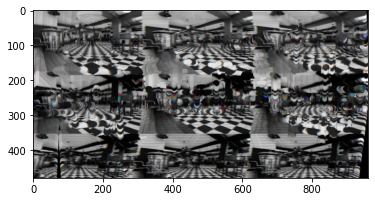

In [362]:
plt.imshow(img)

In [353]:
# from pytorch3d.renderer.points import rasterize_points
# from pytorch3d.renderer import compositing

# pts3D, rgb = get_point_cloud(im_l, im_r, disp)

# print(pts3D.shape)

# pts3D = pts3D * torch.Tensor([1, 1, 1]).unsqueeze(0)

# pts3D = Pointclouds(points=pts3D.to(device), features=rgb.to(device))
# points_idx, _, dist = rasterize_points(pts3D, 300, 0.3, 10)
# dist = dist / pow(0.03, 2)

# alphas = (
#             (1 - dist.clamp(max=1, min=1e-3).pow(0.5))
#             .pow(1)
#             .permute(0, 3, 1, 2)
#         )


# transformed_src_alphas = compositing.alpha_composite(
#                 points_idx.permute(0, 3, 1, 2).long(),
#                 alphas,
#                 pts3D.features_packed().permute(1,0),
#             )

# img = transformed_src_alphas[0].detach().cpu().permute(1, 2, 0)